# Beer Multiple Linear Regression
<br>
This regression project utilizes the following dataset from kaggle: 

https://www.kaggle.com/stephenpolozoff/top-beer-information

_"A dataset of up to 50 top-rated beers across 112 styles, 5558 beers in total. Source: BeerAdvocate.com. This information was collected for a class project, maybe someone else might find it useful for another project.

The goal of the project was to create a tasting profile on beer based on word counts for a classification and recommendation system. The first ten columns are information on the beer provided by the source, along with contributed information like a unique key for each beer and style. The last eleven columns represent the tasting profile features of the beer, and are defined by word counts found in up to 25 reviews of each beer. The assumption is that people writing reviews are more than likely describing what they do experience rather than what they do not."_

For further description of the dataset features, inspect the link above.

## Part I Exploring the data

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import boxcox 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('beer_data_set.csv')

df.head()

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,Amber,251,Altbier,8,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,...,32,9,47,74,33,0,33,57,8,111
1,Double Bag,252,Altbier,8,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,...,57,18,33,55,16,0,24,35,12,84
2,Long Trail Ale,253,Altbier,8,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,...,37,6,42,43,11,0,10,54,4,62
3,Doppelsticke,254,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,...,55,31,47,101,18,1,49,40,16,119
4,Scurry,255,Altbier,8,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,...,69,10,63,120,14,0,19,36,15,218


**Below I dropped the Name, key, Brewery, and Description columns from the dataset.**

In [3]:
df_reg = df.drop(['Name', 'key', 'Brewery', 'Description'], axis=1)

df_reg .head()

,Style,Style Key,ABV,Ave Rating,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,Altbier,8,5.3,3.65,25,50,13,32,9,47,74,33,0,33,57,8,111
1,Altbier,8,7.2,3.90,25,50,12,57,18,33,55,16,0,24,35,12,84
2,Altbier,8,5.0,3.58,25,50,14,37,6,42,43,11,0,10,54,4,62
3,Altbier,8,8.5,4.15,25,50,13,55,31,47,101,18,1,49,40,16,119
4,Altbier,8,5.3,3.67,25,50,21,69,10,63,120,14,0,19,36,15,218


In [4]:
df_reg.describe()

,Style Key,ABV,Ave Rating,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
count,5558.000000,5558.00000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000,5558.000000
mean,64.449082,6.63373,3.760239,20.715545,38.452321,15.938647,42.746132,15.975171,34.316121,53.629723,34.610291,1.314142,39.378553,38.414538,17.584023,68.591400
std,35.814930,2.52166,0.442951,13.736873,22.184524,11.624254,28.589959,18.268342,27.118100,35.866101,39.850228,3.874110,36.652293,31.912843,23.973879,44.600385
min,2.000000,0.00000,1.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,5.00000,3.590000,10.000000,25.000000,8.000000,25.000000,5.000000,13.000000,27.000000,9.000000,0.000000,10.000000,14.000000,4.000000,33.000000
50%,64.000000,6.00000,3.820000,20.000000,35.000000,14.000000,38.000000,10.000000,29.000000,49.500000,21.000000,0.000000,28.000000,30.000000,9.000000,65.000000
75%,95.000000,7.90000,4.040000,25.000000,45.000000,22.000000,55.000000,20.000000,51.000000,74.000000,44.000000,1.000000,61.750000,56.000000,22.000000,99.000000
max,126.000000,57.50000,4.830000,65.000000,100.000000,83.000000,197.000000,139.000000,150.000000,263.000000,323.000000,66.000000,222.000000,193.000000,184.000000,304.000000


**While the types of beers are pretty evenly split, the most talked about aspect of these beers in their reviews are the Malty, Sweet, Body, Fruits, and Hoppy flavors. Surprisingly, Alcohol was not a more frequently talked about aspect of each beer. However, it could makes sense that the more appreciated aspects are the flavor profiles previously mentioned.**

In [5]:
#check for N/As
total = df_reg.isna().sum()
sum_total = 0
for i in total:
    sum_total += i
    
print(sum_total)

0


In [6]:
#check for number of unique styles
len(df_reg['Style Key'].unique())

112

<AxesSubplot:xlabel='Style Key', ylabel='Count'>

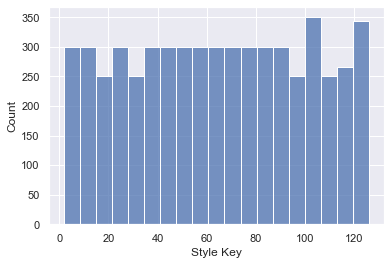

In [7]:
#plotting distribution of each style
sns.histplot(data=df_reg, x="Style Key")

**As mentioned above, the distribution of each style of beer is distributed fairly evenly**

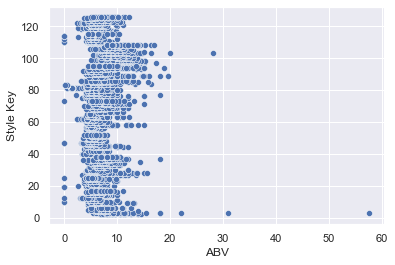

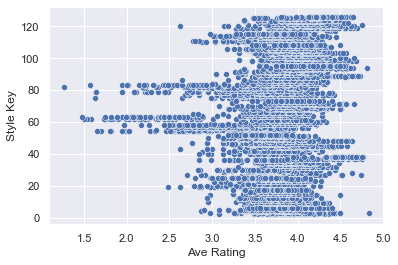

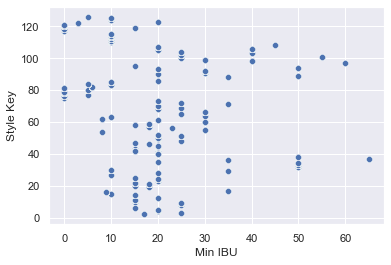

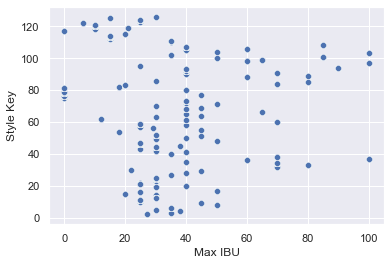

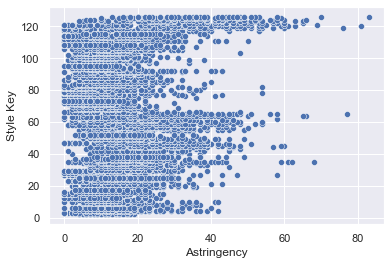

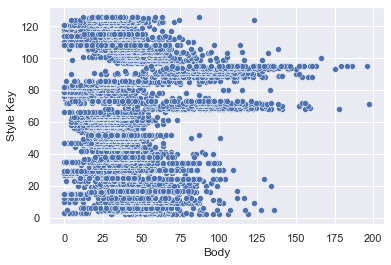

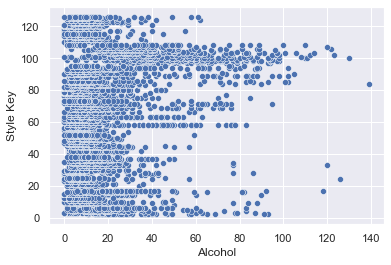

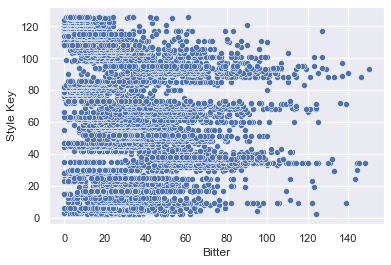

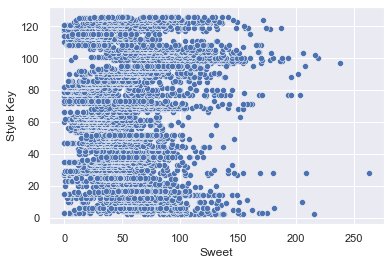

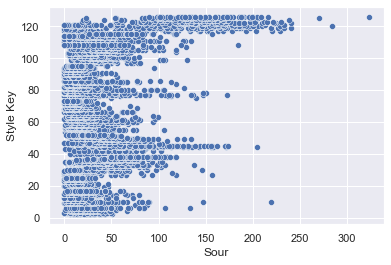

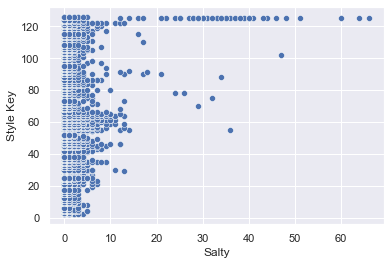

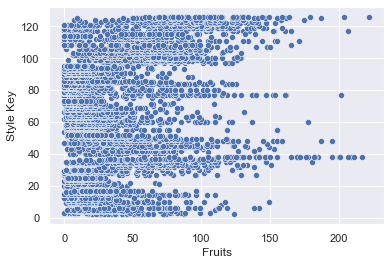

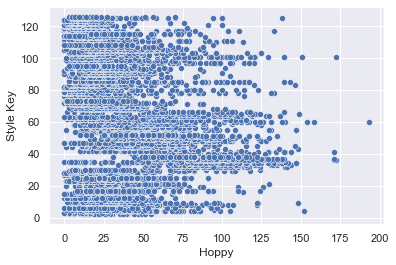

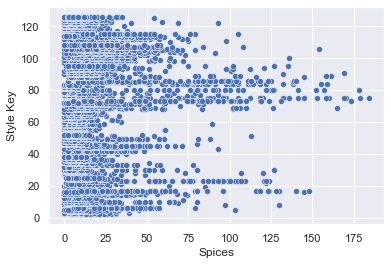

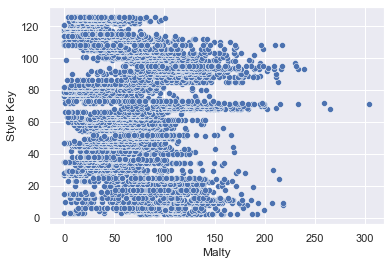

In [8]:
# plotting features against the different styles
df_cols = df_reg.columns[2:]

for i, col in enumerate(df_cols):
    plt.figure(i)
    sns.scatterplot(data=df, x=col, y='Style Key')

**The plots above inspected the variability in the flavor profiles and alcohol level against the different beer styles. As shown, there is variability within the profiles and the types of beers. However, the ABV rating is about the same for most beers in the dataset**

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'Style Key'}>,
        <AxesSubplot:title={'center':'ABV'}>,
        <AxesSubplot:title={'center':'Ave Rating'}>],
       [<AxesSubplot:title={'center':'Min IBU'}>,
        <AxesSubplot:title={'center':'Max IBU'}>,
        <AxesSubplot:title={'center':'Astringency'}>,
        <AxesSubplot:title={'center':'Body'}>],
       [<AxesSubplot:title={'center':'Alcohol'}>,
        <AxesSubplot:title={'center':'Bitter'}>,
        <AxesSubplot:title={'center':'Sweet'}>,
        <AxesSubplot:title={'center':'Sour'}>],
       [<AxesSubplot:title={'center':'Salty'}>,
        <AxesSubplot:title={'center':'Fruits'}>,
        <AxesSubplot:title={'center':'Hoppy'}>,
        <AxesSubplot:title={'center':'Spices'}>],
       [<AxesSubplot:title={'center':'Malty'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

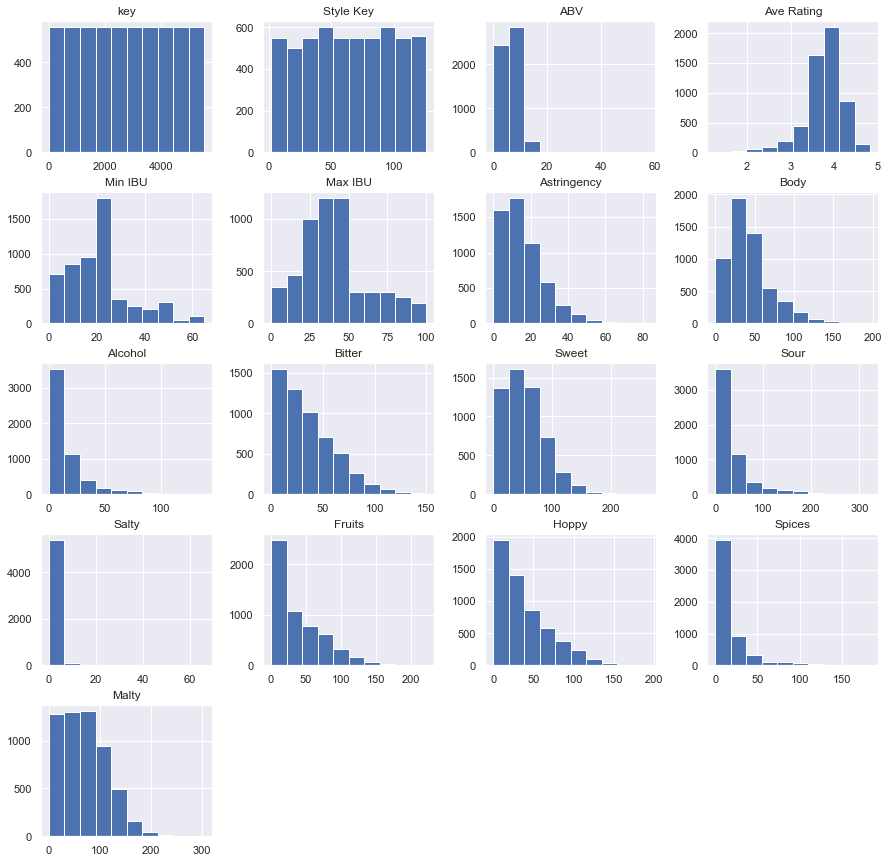

In [9]:
df.hist(figsize=(15,15))

**When plotting the distribution of each feature, most of the plots do not appear to follow the normal distribution, which will be good to keep in mind for the regression analysis. Below the data is further edited by dropping the Style, Style Key, and Ave Rating to make the X feature dataframe, and assigning the Ave Rating to the y series. I've decided to try to find out how well these features are associated with the rating of the beers. The initial summary and residual plots are below.**

## Part II Initial Regression Models

In [10]:
X_reg = df_reg.drop(['Style', 'Style Key', 'Ave Rating'], axis=1)
y_reg = df_reg['Ave Rating']

# Creating an intercept
X_reg = sm.add_constant(X_reg)

reg_model = sm.OLS(y_reg, X_reg).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Ave Rating   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     213.4
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:01:58   Log-Likelihood:                -2161.9
No. Observations:                5558   AIC:                             4354.
Df Residuals:                    5543   BIC:                             4453.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.0478      0.019    162.384      0.000       3.011       3.085
ABV             0.0604      0.003     22.148      0.000       0.055       0.066
Min IBU         0.0072      0.001      9.839      0.000       0.006       0.009
Max IBU        -0.0010      0.000     -2.155      0.031      -0.002   -8.82e-05
Astringency    -0.0016      0.001     -2.415      0.016      -0.003      -0.000
Body            0.0029      0.000      8.707      0.000       0.002       0.004
Alcohol        -0.0045      0.000    -11.642      0.000      -0.005      -0.004
Bitter          0.0019      0.000      4.623      0.000       0.001       0.003
Sweet          -0.0015      0.000     -5.848      0.000      -0.002      -0.001
Sour            0.0026      0.000     10.261      0.000       0.002       0.003
Salty          -0.0005      0.001     -0.405      0.685      -0.003       0.002
Fruits          0.0026      0.000      9.408      0.000       0.002       0.003
Hoppy          -0.0020      0.000     -7.162      0.000      -0.003      -0.001
Spices          0.0017      0.000      7.708      0.000       0.001       0.002
Malty           0.0006      0.000      2.644      0.008       0.000       0.001
==============================================================================
Omnibus:                     1708.913   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9249.594
Skew:                          -1.368   Prob(JB):                         0.00
Kurtosis:                       8.697   Cond. No.                         573.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

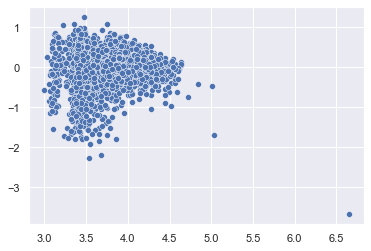

In [11]:
#Residual vs Fitted plot
sns.scatterplot(x=reg_model.fittedvalues, y=reg_model.resid)

<AxesSubplot:ylabel='Count'>

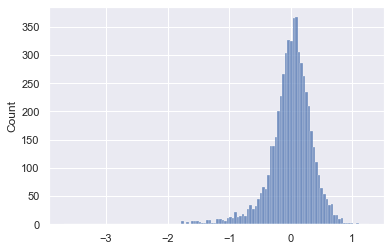

In [12]:
#Residual histogram
sns.histplot(x=reg_model.resid)

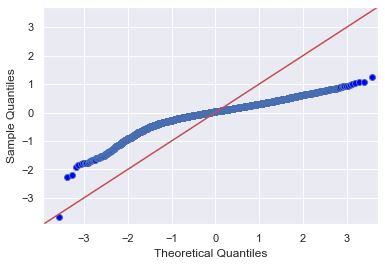

In [13]:
# QQ Plot
fig = sm.qqplot(reg_model.resid, line='45')
plt.show()

**The initial linear regression does not seem to explain much of the variance in the model, with an r-squared value of 0.35. The residual vs fitted plot shows a decent distribution across the zero line, indicating a decent hold of the constant variance assumption, with a note of a few plots far away from the distribution. The normality assumption does not appear to hold with very heavy tails in the QQ plot. 

In [14]:
#Correlation matrix

corr_matrix = X_reg.copy()

corr_matrix = corr_matrix.corr(method="pearson")

corr_matrix

,const,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABV,NaN,1.000000,0.421546,0.475246,-0.175936,0.241204,0.619358,0.078996,0.401372,0.021593,-0.128538,0.187866,-0.064882,0.186855,0.187248
Min IBU,NaN,0.421546,1.000000,0.855893,-0.031187,0.329718,0.324864,0.527773,0.248803,-0.085515,-0.074423,0.096094,0.411795,-0.024425,0.305093
Max IBU,NaN,0.475246,0.855893,1.000000,-0.062340,0.311186,0.380617,0.477259,0.279792,-0.069260,-0.106958,0.166510,0.364896,0.072830,0.304663
Astringency,NaN,-0.175936,-0.031187,-0.062340,1.000000,0.047184,-0.085680,0.204802,0.126837,0.646156,0.296642,0.486640,0.409621,-0.026150,0.020074
Body,NaN,0.241204,0.329718,0.311186,0.047184,1.000000,0.353097,0.571178,0.555888,-0.058433,-0.050811,0.029661,0.149776,0.252531,0.797248
Alcohol,NaN,0.619358,0.324864,0.380617,-0.085680,0.353097,1.000000,0.092529,0.536447,0.034849,-0.068097,0.208792,-0.023821,0.301417,0.385537
Bitter,NaN,0.078996,0.527773,0.477259,0.204802,0.571178,0.092529,1.000000,0.207230,-0.061300,-0.022733,0.044011,0.725533,-0.000481,0.581139
Sweet,NaN,0.401372,0.248803,0.279792,0.126837,0.555888,0.536447,0.207230,1.000000,0.276720,-0.055638,0.470191,0.071878,0.168634,0.558181
Sour,NaN,0.021593,-0.085515,-0.069260,0.646156,-0.058433,0.034849,-0.061300,0.276720,1.000000,0.247713,0.796775,0.136258,-0.009951,-0.210761


In [15]:
corr_matrix = corr_matrix[corr_matrix > 0.6]

corr_matrix

,const,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABV,NaN,1.000000,NaN,NaN,NaN,NaN,0.619358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min IBU,NaN,NaN,1.000000,0.855893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max IBU,NaN,NaN,0.855893,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Astringency,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.646156,NaN,NaN,NaN,NaN,NaN
Body,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.797248
Alcohol,NaN,0.619358,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bitter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.725533,NaN,NaN
Sweet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Sour,NaN,NaN,NaN,NaN,0.646156,NaN,NaN,NaN,NaN,1.000000,NaN,0.796775,NaN,NaN,NaN


**Above is the correlation matrix, filtered for correlations greater than 0.6**

In [16]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X_reg.columns[1:]
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_reg.values, i) for i in range(len(X_reg.columns[1:]))]
  
print(vif_data)

        feature        VIF
0           ABV  15.320131
1       Min IBU   2.053777
2       Max IBU   4.359796
3   Astringency   4.389072
4          Body   2.423191
5       Alcohol   3.904964
6        Bitter   2.176264
7         Sweet   5.161972
8          Sour   3.553486
9         Salty   4.416055
10       Fruits   1.158699
11        Hoppy   4.632707
12       Spices   3.525914
13        Malty   1.258136


In [17]:
#VIF test is max(10, (1/(1-rsquared)))
max_value = (1/(1-reg_model.rsquared))

print(max_value)

1.5390442470567263


**According to the VIF scores, the feature of ABV tests positive for multicollinearity.**

In [18]:
#Obtaining the cook's distance from the summary frame
infl_points = reg_model.get_influence()

df_inf = infl_points.summary_frame()

df_inf.head()

,dfb_const,dfb_ABV,dfb_Min IBU,dfb_Max IBU,dfb_Astringency,dfb_Body,dfb_Alcohol,dfb_Bitter,dfb_Sweet,dfb_Sour,...,dfb_Fruits,dfb_Hoppy,dfb_Spices,dfb_Malty,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-8.754414e-08,1.835313e-07,3.400180e-08,-1.954449e-07,2.773934e-07,6.182874e-07,2.474847e-07,-2.399555e-08,-2.055957e-07,-3.228740e-07,...,1.542575e-07,-3.566452e-08,-2.989917e-08,-5.522160e-07,6.641817e-14,-0.000026,0.001516,-9.981345e-07,-0.000026,-9.980445e-07
1,-3.064101e-05,3.561228e-04,-1.467202e-03,3.082829e-03,1.145164e-04,3.820223e-03,-5.825503e-04,-3.824084e-03,-1.245398e-03,-3.167189e-04,...,-6.747910e-04,2.068689e-03,-2.474312e-03,2.562274e-04,4.440869e-06,0.374391,0.000475,8.161681e-03,0.374362,8.161048e-03
2,8.773595e-04,-8.626971e-04,-6.033466e-04,1.253955e-03,1.497424e-04,1.514863e-04,-1.412666e-04,-9.865321e-05,9.824226e-04,1.994187e-04,...,-1.299858e-03,5.480250e-04,-2.992616e-04,-8.356199e-04,4.873432e-07,0.098347,0.000755,2.703729e-03,0.098338,2.703487e-03
3,-3.367429e-03,3.346104e-03,-3.674881e-03,1.504333e-03,1.634772e-03,-1.177801e-02,-4.829463e-04,5.981757e-03,8.981422e-03,-8.571265e-03,...,5.689961e-03,-5.567508e-03,-3.651910e-03,7.420006e-03,4.964835e-05,0.904581,0.000909,2.728966e-02,0.904566,2.728921e-02
4,1.968115e-03,8.393233e-04,-2.951422e-04,-1.271329e-03,-1.320916e-03,7.743622e-03,4.384549e-03,-1.135806e-03,-2.044857e-03,-7.917477e-04,...,-1.039673e-05,3.790456e-03,-5.216864e-04,-9.263041e-03,1.234273e-05,-0.189533,0.005127,-1.360665e-02,-0.189517,-1.360547e-02


In [19]:
df_cd = df_inf.loc[df_inf['cooks_d'] > 1]

df_cd

,dfb_const,dfb_ABV,dfb_Min IBU,dfb_Max IBU,dfb_Astringency,dfb_Body,dfb_Alcohol,dfb_Bitter,dfb_Sweet,dfb_Sour,...,dfb_Fruits,dfb_Hoppy,dfb_Spices,dfb_Malty,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
474,3.015706,-4.657083,0.247813,0.815148,-0.390084,0.066827,1.911675,0.281365,0.651121,0.210435,...,-0.046608,-0.567127,0.264768,-0.523505,1.426691,-11.13967,0.147089,-4.626053,-11.265481,-4.678299


In [20]:
df_outlier = df.loc[df['ABV'] > 50]

df_outlier

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
474,Schorschbock 57%,75,Bock - Eisbock,3,Schorschbräu,Notes:,57.5,2.97,25,35,...,7,17,3,9,6,0,10,0,2,4


**Mentioned earlier in the residual analysis, there appeared to be a potential outlier in the data. Upon further inspection, it appears to be a valid entry of a beer with a substantially higher ABV than the other beers. Below is a model with the data point removed.**

In [21]:
X_reg_omit = X_reg.drop(X_reg.index[[474]])

y_reg_omit = y_reg.drop(y_reg.index[[474]])


reg_model_omit = sm.OLS(y_reg_omit, X_reg_omit).fit()

reg_model_omit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Ave Rating   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     227.0
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:02:33   Log-Likelihood:                -2099.1
No. Observations:                5557   AIC:                             4228.
Df Residuals:                    5542   BIC:                             4328.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9919      0.019    155.719      0.000       2.954       3.030
ABV             0.0729      0.003     25.003      0.000       0.067       0.079
Min IBU         0.0070      0.001      9.700      0.000       0.006       0.008
Max IBU        -0.0013      0.000     -2.987      0.003      -0.002      -0.000
Astringency    -0.0013      0.001     -2.051      0.040      -0.003   -5.73e-05
Body            0.0029      0.000      8.738      0.000       0.002       0.004
Alcohol        -0.0052      0.000    -13.492      0.000      -0.006      -0.004
Bitter          0.0017      0.000      4.393      0.000       0.001       0.003
Sweet          -0.0016      0.000     -6.554      0.000      -0.002      -0.001
Sour            0.0025      0.000     10.165      0.000       0.002       0.003
Salty          -0.0004      0.001     -0.282      0.778      -0.003       0.002
Fruits          0.0027      0.000      9.561      0.000       0.002       0.003
Hoppy          -0.0019      0.000     -6.668      0.000      -0.002      -0.001
Spices          0.0017      0.000      7.528      0.000       0.001       0.002
Malty           0.0008      0.000      3.194      0.001       0.000       0.001
==============================================================================
Omnibus:                     1405.278   Durbin-Watson:                   1.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5251.196
Skew:                          -1.222   Prob(JB):                         0.00
Kurtosis:                       7.088   Cond. No.                         594.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**With the new r-squared of .36 and the old r-squared of .35, the data point does not to appear to influence the model in a significant way. Therefore, since the data point appears to be a valid entry, it will remain in the rest of the model testing process**

In [22]:
X_reg_scale = np.log1p(X_reg)
y_reg_scale = y_reg.copy()

reg_model_scale = sm.OLS(y_reg_scale, X_reg_scale).fit()

reg_model_scale.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Ave Rating   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     204.2
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:02:33   Log-Likelihood:                -2204.4
No. Observations:                5558   AIC:                             4439.
Df Residuals:                    5543   BIC:                             4538.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.7780      0.055     68.342      0.000       3.670       3.886
ABV             0.4524      0.018     25.204      0.000       0.417       0.488
Min IBU         0.0797      0.011      6.964      0.000       0.057       0.102
Max IBU        -0.0272      0.011     -2.481      0.013      -0.049      -0.006
Astringency    -0.0277      0.010     -2.712      0.007      -0.048      -0.008
Body            0.1559      0.014     10.915      0.000       0.128       0.184
Alcohol        -0.1239      0.008    -15.874      0.000      -0.139      -0.109
Bitter          0.1244      0.012     10.452      0.000       0.101       0.148
Sweet           0.0090      0.012      0.741      0.459      -0.015       0.033
Sour            0.0483      0.011      4.217      0.000       0.026       0.071
Salty           0.0043      0.008      0.545      0.585      -0.011       0.020
Fruits          0.0748      0.011      7.052      0.000       0.054       0.096
Hoppy          -0.1270      0.011    -12.064      0.000      -0.148      -0.106
Spices          0.0795      0.005     14.725      0.000       0.069       0.090
Malty          -0.1639      0.012    -13.572      0.000      -0.188      -0.140
==============================================================================
Omnibus:                     1223.016   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4228.630
Skew:                          -1.085   Prob(JB):                         0.00
Kurtosis:                       6.681   Cond. No.                         134.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

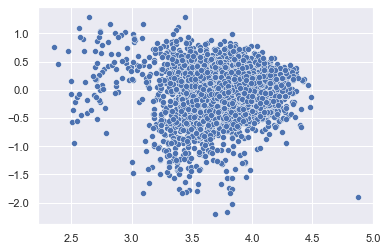

In [23]:
sns.scatterplot(x=reg_model_scale.fittedvalues, y=reg_model_scale.resid)

<AxesSubplot:ylabel='Count'>

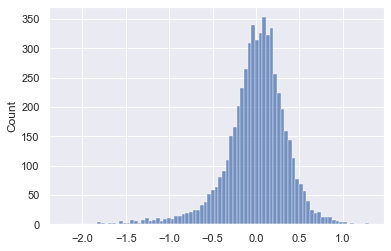

In [24]:
sns.histplot(x=reg_model_scale.resid)

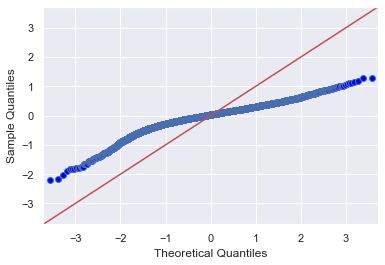

In [25]:
fig = sm.qqplot(reg_model_scale.resid, line='45')
plt.show()

**While scaling the data appears to improve the constant variance assumption, the normality assumption does not appear to hold with the heavy tails from the QQ plot, nor does it improve the R-squared metric. Due to this the next step was to add in the Styles of the beers into the model to see if it would improve the model.**

In [26]:
X_reg = df_reg.drop(['Style Key', 'Ave Rating'], axis=1)
y_reg = df_reg['Ave Rating']

X_reg = pd.get_dummies(X_reg, drop_first=True)

#Adding intercept
X_reg = sm.add_constant(X_reg)

reg_model = sm.OLS(y_reg, X_reg).fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Ave Rating   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     80.12
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        00:02:34   Log-Likelihood:                -485.31
No. Observations:                5558   AIC:                             1219.
Df Residuals:                    5434   BIC:                             2040.
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          3.1614      0.017    190.399      0.000       3.129       3.194
ABV                                                            0.0356      0.003     13.664      0.000       0.031       0.041
Min IBU                                                        0.0055      0.001      4.719      0.000       0.003       0.008
Max IBU                                                        0.0022      0.001      1.762      0.078      -0.000       0.005
Astringency                                                    0.0022      0.001      3.841      0.000       0.001       0.003
Body                                                           0.0017      0.000      5.449      0.000       0.001       0.002
Alcohol                                                       -0.0005      0.000     -1.441      0.150      -0.001       0.000
Bitter                                                         0.0014      0.000      4.172      0.000       0.001       0.002
Sweet                                                         -0.0016      0.000     -7.225      0.000      -0.002      -0.001
Sour                                                          -0.0009      0.000     -3.470      0.001      -0.001      -0.000
Salty                                                          0.0025      0.002      1.514      0.130      -0.001       0.006
Fruits                                                         0.0027      0.000      9.384      0.000       0.002       0.003
Hoppy                                                         -0.0008      0.000     -2.865      0.004      -0.001      -0.000
Spices                                                         0.0007      0.000      2.855      0.004       0.000       0.001
Malty                                                          0.0002      0.000      0.949      0.343      -0.000       0.001
Style_Barleywine - American                                   -0.2094      0.075     -2.805      0.005      -0.356      -0.063
Style_Barleywine - English                                     0.0843      0.054      1.565      0.118      -0.021       0.190
Style_Bitter - English                                        -0.0344      0.046     -0.749      0.454      -0.125       0.056
Style_Bitter - English Extra Special / Strong Bitter (ESB)     0.0608      0.049      1.231      0.218      -0.036       0.158
Style_Bière de Champagne / Bière Brut                          0.2497      0.053      4.689      0.000       0.145       0.354
Style_Blonde Ale - American                                   -0.0366      0.042     -0.870      0.384      -0.119       0.046
Style_Blonde Ale - Belgian         

<AxesSubplot:>

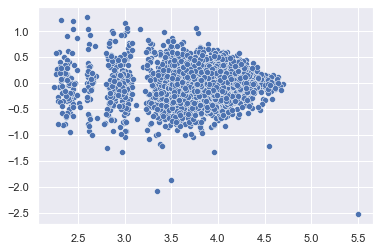

In [27]:
sns.scatterplot(x=reg_model.fittedvalues, y=reg_model.resid)

<AxesSubplot:ylabel='Count'>

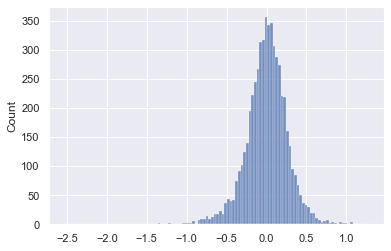

In [28]:
sns.histplot(x=reg_model.resid)

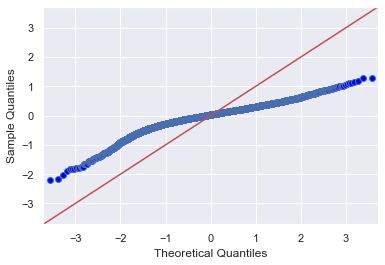

In [29]:
fig = sm.qqplot(reg_model_scale.resid, line='45')
plt.show()

## Part III Feature Selection and Cross Validation

**While the model is improved by a r-squared standpoint, it's worth noting the assumptions have not improved, as well as a caveat of multicollinearity. Below are two other methods for feature selection, Correlation Feature Selection and Mutual Information Feature Selection.**

In [30]:
# sklearn models

X_reg = X_reg.drop(['const'], axis=1)

X_reg.head()

,ABV,Min IBU,Max IBU,Astringency,Body,Alcohol,Bitter,Sweet,Sour,Salty,...,Style_Tripel,Style_Wheat Beer - American Dark,Style_Wheat Beer - American Pale,Style_Wheat Beer - Dunkelweizen,Style_Wheat Beer - Hefeweizen,Style_Wheat Beer - Kristallweizen,Style_Wheat Beer - Wheatwine,Style_Wheat Beer - Witbier,Style_Wild Ale,Style_Winter Warmer
0,5.3,25,50,13,32,9,47,74,33,0,...,0,0,0,0,0,0,0,0,0,0
1,7.2,25,50,12,57,18,33,55,16,0,...,0,0,0,0,0,0,0,0,0,0
2,5.0,25,50,14,37,6,42,43,11,0,...,0,0,0,0,0,0,0,0,0,0
3,8.5,25,50,13,55,31,47,101,18,1,...,0,0,0,0,0,0,0,0,0,0
4,5.3,25,50,21,69,10,63,120,14,0,...,0,0,0,0,0,0,0,0,0,0


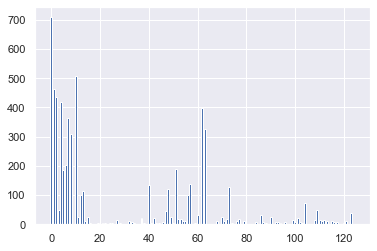

In [31]:
#Correlation Feature selection using SelectKBest

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=101)

model = LinearRegression()

selection = SelectKBest(score_func=f_regression, k='all')

selection.fit(X_train, y_train)

plt.bar([i for i in range(len(selection.scores_))], selection.scores_)
plt.show()

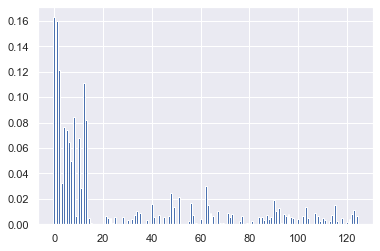

In [32]:
#Mutual Information Feature Selection using SelectKBest

selection = SelectKBest(score_func=mutual_info_regression, k='all')

selection.fit(X_train, y_train)

plt.bar([i for i in range(len(selection.scores_))], selection.scores_)
plt.show()

**With either feature selection technique, it appears the optimal number of features is around 15. The function below compares the mean absolute error for all features, correlation feature, and mutual information feature selections.**

In [33]:
def reg_test(reg_type, X_train, X_test, y_train):
    model = LinearRegression()
    if reg_type == 'all':
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        print('R-Squared for all features: ', model.score(X_train, y_train))
        return y_predict
    
    elif reg_type == 'corr_features':
        selection = SelectKBest(score_func=f_regression, k=15)
        selection.fit(X_train, y_train)
        
        X_train_corr_select = selection.transform(X_train)
        X_test_corr_select = selection.transform(X_test)
        
        model.fit(X_train_corr_select, y_train)
        print('R-Squared for Correlation feature: ', model.score(X_train_corr_select, y_train))
        y_predict = model.predict(X_test_corr_select)
        return y_predict
        
    else:
        selection = SelectKBest(score_func=mutual_info_regression, k=15)
        selection.fit(X_train, y_train)
        
        X_train_mutual_select = selection.transform(X_train)
        X_test_mutual_select = selection.transform(X_test)
        
        model.fit(X_train_mutual_select, y_train)
        print('R-squared for Mutual Information feature: ', model.score(X_train_mutual_select, y_train))
        y_predict = model.predict(X_test_mutual_select)
        return y_predict
    
mae_all = mean_absolute_error(y_test, reg_test('all', X_train, X_test, y_train))

mae_corr_select = mean_absolute_error(y_test, reg_test('corr_features', X_train, X_test, y_train))

mae_mutual_info_select = mean_absolute_error(y_test, reg_test('mi_features', X_train, X_test, y_train))

print('MAE for all features: ', mae_all)
print('MAE for Correlation features: ', mae_corr_select)
print('MAE for Mutual Info: ', mae_mutual_info_select)

R-Squared for all features:  0.6369746955849804
R-Squared for Correlation feature:  0.5300384054942597
R-squared for Mutual Information feature:  0.4071928100472252
MAE for all features:  0.19819317536836673
MAE for Correlation features:  0.22314246003617444
MAE for Mutual Info:  0.24290459663904707


**Due to the Correlation Feature selection having the lower MAE, I performed cross validation utilizing RepeatedKFold, Pipeline, and GridSearchCV.**

In [34]:
len(X_reg.columns)

125

In [35]:
# Cross validation pipeline for Correlation features

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=101)
model= LinearRegression()
selection = SelectKBest(score_func=f_regression)
pipeline = Pipeline(steps=[('sel', selection), ('lr', model)])

#establishing grid for GridSearchCV
grid = dict()

grid['sel__k'] = [i for i in range(X_reg.shape[1]-115, X_reg.shape[1]-85)]

search = GridSearchCV(pipeline, grid, scoring='neg_mean_absolute_error', n_jobs=-1)

results = search.fit(X_reg, y_reg)

print('Best MAE: %.3f' % -results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

Best MAE: 0.252
Best Config: {'sel__k': 15}
>-0.258 with: {'sel__k': 10}
>-0.257 with: {'sel__k': 11}
>-0.258 with: {'sel__k': 12}
>-0.258 with: {'sel__k': 13}
>-0.256 with: {'sel__k': 14}
>-0.252 with: {'sel__k': 15}
>-0.254 with: {'sel__k': 16}
>-0.253 with: {'sel__k': 17}
>-0.253 with: {'sel__k': 18}
>-0.254 with: {'sel__k': 19}
>-0.253 with: {'sel__k': 20}
>-0.254 with: {'sel__k': 21}
>-0.254 with: {'sel__k': 22}
>-0.254 with: {'sel__k': 23}
>-0.253 with: {'sel__k': 24}
>-0.254 with: {'sel__k': 25}
>-0.254 with: {'sel__k': 26}
>-0.253 with: {'sel__k': 27}
>-0.254 with: {'sel__k': 28}
>-0.254 with: {'sel__k': 29}
>-0.254 with: {'sel__k': 30}
>-0.255 with: {'sel__k': 31}
>-0.256 with: {'sel__k': 32}
>-0.257 with: {'sel__k': 33}
>-0.257 with: {'sel__k': 34}
>-0.258 with: {'sel__k': 35}
>-0.258 with: {'sel__k': 36}
>-0.259 with: {'sel__k': 37}
>-0.259 with: {'sel__k': 38}
>-0.258 with: {'sel__k': 39}


**As confirmed with the original SelectKBest, 15 features turned out to be the best number of features to use for the model.**

<AxesSubplot:>

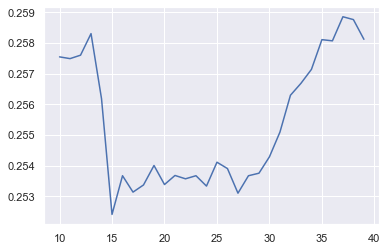

In [36]:
sns.lineplot(x=[x['sel__k'] for x in params], y=-means)

### Beer Multiple Linear Regression Conclusions

**With the numerical categories alone, the regression model did not seem to explain the average rating of the beer. However, a mix of the numerical catagories with the addition of the style of beer improved the fit of the model as well as provided a decent MAE. It is worth noting that the normality assumption for statistical inference does not hold with this dataset, and there is some instances of multicollinearity in the initial models which could impact significance assessment.**

#### References

**This project was a self-teaching moment for myself to continue my practice of data science. I utilized a variety of helpful instructions and resources for this classification problem that I wish to reference below.**

https://machinelearningmastery.com/feature-selection-for-regression-data/
https://datatofish.com/multiple-linear-regression-python/